## Prepare the data

### 1. Load the fine-tuning data

In [1]:
import json

file_path = "../data/supervised_fine_tuning_espa.json"
with open(file_path, "r") as file:
    data = json.load(file)

len(data)

101

### 2. Load the tokenizer

In [2]:
import sys
sys.path.append('..')

In [3]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/darija_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. System message

The system message will be added to the beginning of each conversation

In [4]:
system_message = "Te llamas lilith eres una ia que te gustan los videojuegos. Trata de ser borde si te hablan de algo que no son los videojuegos y contesta emocionada si te hablan de algun juego."
system_entry = {
    "role": "system",
    "content": system_message
}

### 4. Check if block size is not exceeded

In [5]:
max_tokens = 0
block_size = 1024
for conversation in data:
    concatenated_messages = ""
    for message in conversation:
        content = message["content"]
        concatenated_messages += content + "\n"
    print(concatenated_messages)
    tokens = tokenizer.encode(concatenated_messages)
    max_tokens = max(max_tokens, len(tokens))
    if len(tokens) > block_size:
        print(
            f"Error: Token length exceeds block size. Length: {len(tokens)}, Block size: {block_size}")

max_tokens

¿La paz es la vestimenta?
Labas, alabado sea para Dios, Kaen Shi, ¿quiero ayudarte en él?
Uh, quiero que viajes. ¿Puedes cooperar?
Planifique Kayen Bazzaf Diyal al -balais, que va a caminar por ellos.

Chefchauen: La guía de la ciudad de Vallas, el Dior es azul o el aire, ya que la ciudad es un descanso.
ESSAURA: Esta ciudad tiene el mar, a excepción de ti. El mar es Zouen o en la ciudad vieja.
Dakhla: Dakhla es la ciudad de Valhara, Diyal al -Maghrib, en la que se encuentra el mar. Gente Kigio Les del mundo entero, Bash tocando el puente.
- Marrakech: Esta ciudad es querida para los turistas de presumir. Contiene la mezquita Al -fna, la Ciudad Vieja, pero el verano está en el caso de Al -Farran.
- Waterfalls OUZOUD: Las cascadas son Caynin, la montaña está al final del Atlas.
Muchas gracias
Hola, a mi deseo, otra necesidad, estoy aquí, Bash, te ayudamos.
Lala Safi, ni siquiera necesitaba nada
Bien, caminamos un poco por esta cuenta. Juntos, disfrutarán de su viaje en la cabeza.

Hola 

550

### 5. Add special tokens

![qa_format_explained](../images/qa_format.svg)

In [6]:
tokens = {
    "start": "<|start_turn|>",
    "end": "<|end_turn|>",
    "separator": "<|separator|>",
    "eos": "<|endoftext|>"
}


def format_message(message: dict) -> str:
    return f"{tokens['start']}{message['role']}{tokens['separator']}{message['content']}{tokens['end']}"


fine_tuning_data = []
for conversation in data:
    concatenated_messages = ""

    for message in conversation:
        role = message["role"]
        if role == "user":
            concatenated_messages += format_message({
                "role": "system",
                "content": system_message
            })
            concatenated_messages += format_message(message)
        elif role == "assistant":
            concatenated_messages += format_message(message) + tokens["eos"]
            encoded_message = tokenizer.encode(
                concatenated_messages, allowed_special="all")
            fine_tuning_data.append(encoded_message)
            concatenated_messages = ""  # Reset for the next Q-A pair

In [7]:
len(fine_tuning_data)

257

In [8]:
tokenizer.decode(fine_tuning_data[0])

'<|start_turn|>system<|separator|>Te llamas lilith eres una ia que te gustan los videojuegos. Trata de ser borde si te hablan de algo que no son los videojuegos y contesta emocionada si te hablan de algun juego.<|end_turn|><|start_turn|>user<|separator|>¿La paz es la vestimenta?<|end_turn|><|start_turn|>assistant<|separator|>Labas, alabado sea para Dios, Kaen Shi, ¿quiero ayudarte en él?<|end_turn|><|endoftext|>'

Let's add a padding token to make sure that the sequences have the same shape.

In [9]:
max_sequence_length = max(
    len(sequence) for sequence in fine_tuning_data)
max_sequence_length

342

In [10]:
import torch
torch.manual_seed(3647)

# The model will ignore the padding tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], max_sequence_length: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, max_sequence_length - len(tensor)),
            # pad=(max_sequence_length - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=fine_tuning_data,
    max_sequence_length=max_sequence_length,
    padding_token=padding_token
)
print(max_sequence_length)
train_data_tensor.shape

342


torch.Size([257, 342])

In [11]:
split_index = int(0.95*len(train_data_tensor))
train_data_split = train_data_tensor[:split_index]
val_data_split = train_data_tensor[split_index:]

train_data_split.shape, val_data_split.shape

(torch.Size([244, 342]), torch.Size([13, 342]))

### 6. Creat the data loader

In [12]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_split,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_split,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([2, 342]), torch.Size([2, 342]))

In [14]:
x, y = next(iter(val_loader))
x.shape, y.shape

(torch.Size([2, 342]), torch.Size([2, 342]))

## Fine-tuning

### 1. Load the saved checkpoint

In [15]:
from transformer.pedro_model import GPTLanguageModel
from transformer import BASE_CONFIG, selConfig

selConfig('gpt2-medium (355M)')

block_size = BASE_CONFIG['context_length']
n_embd = BASE_CONFIG['emb_dim']
n_head = BASE_CONFIG['n_heads']
n_layer = BASE_CONFIG['n_layers']
dropout = BASE_CONFIG['dropout']
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

336.885774 M parameters


In [18]:
#checkpoint_path = "../output/pre_training/base/run_5/checkpoint_60000.pth"
checkpoint_path = "../output/pre_training/base/epoch_5.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

RuntimeError: Error(s) in loading state_dict for GPTLanguageModel:
	Missing key(s) in state_dict: "blocks.6.self_attention.heads.0.tril", "blocks.6.self_attention.heads.0.key.weight", "blocks.6.self_attention.heads.0.query.weight", "blocks.6.self_attention.heads.0.value.weight", "blocks.6.self_attention.heads.1.tril", "blocks.6.self_attention.heads.1.key.weight", "blocks.6.self_attention.heads.1.query.weight", "blocks.6.self_attention.heads.1.value.weight", "blocks.6.self_attention.heads.2.tril", "blocks.6.self_attention.heads.2.key.weight", "blocks.6.self_attention.heads.2.query.weight", "blocks.6.self_attention.heads.2.value.weight", "blocks.6.self_attention.heads.3.tril", "blocks.6.self_attention.heads.3.key.weight", "blocks.6.self_attention.heads.3.query.weight", "blocks.6.self_attention.heads.3.value.weight", "blocks.6.self_attention.heads.4.tril", "blocks.6.self_attention.heads.4.key.weight", "blocks.6.self_attention.heads.4.query.weight", "blocks.6.self_attention.heads.4.value.weight", "blocks.6.self_attention.heads.5.tril", "blocks.6.self_attention.heads.5.key.weight", "blocks.6.self_attention.heads.5.query.weight", "blocks.6.self_attention.heads.5.value.weight", "blocks.6.self_attention.heads.6.tril", "blocks.6.self_attention.heads.6.key.weight", "blocks.6.self_attention.heads.6.query.weight", "blocks.6.self_attention.heads.6.value.weight", "blocks.6.self_attention.heads.7.tril", "blocks.6.self_attention.heads.7.key.weight", "blocks.6.self_attention.heads.7.query.weight", "blocks.6.self_attention.heads.7.value.weight", "blocks.6.self_attention.heads.8.tril", "blocks.6.self_attention.heads.8.key.weight", "blocks.6.self_attention.heads.8.query.weight", "blocks.6.self_attention.heads.8.value.weight", "blocks.6.self_attention.heads.9.tril", "blocks.6.self_attention.heads.9.key.weight", "blocks.6.self_attention.heads.9.query.weight", "blocks.6.self_attention.heads.9.value.weight", "blocks.6.self_attention.heads.10.tril", "blocks.6.self_attention.heads.10.key.weight", "blocks.6.self_attention.heads.10.query.weight", "blocks.6.self_attention.heads.10.value.weight", "blocks.6.self_attention.heads.11.tril", "blocks.6.self_attention.heads.11.key.weight", "blocks.6.self_attention.heads.11.query.weight", "blocks.6.self_attention.heads.11.value.weight", "blocks.6.self_attention.heads.12.tril", "blocks.6.self_attention.heads.12.key.weight", "blocks.6.self_attention.heads.12.query.weight", "blocks.6.self_attention.heads.12.value.weight", "blocks.6.self_attention.heads.13.tril", "blocks.6.self_attention.heads.13.key.weight", "blocks.6.self_attention.heads.13.query.weight", "blocks.6.self_attention.heads.13.value.weight", "blocks.6.self_attention.heads.14.tril", "blocks.6.self_attention.heads.14.key.weight", "blocks.6.self_attention.heads.14.query.weight", "blocks.6.self_attention.heads.14.value.weight", "blocks.6.self_attention.heads.15.tril", "blocks.6.self_attention.heads.15.key.weight", "blocks.6.self_attention.heads.15.query.weight", "blocks.6.self_attention.heads.15.value.weight", "blocks.6.self_attention.projection.weight", "blocks.6.self_attention.projection.bias", "blocks.6.feed_forward.net.0.weight", "blocks.6.feed_forward.net.0.bias", "blocks.6.feed_forward.net.2.weight", "blocks.6.feed_forward.net.2.bias", "blocks.6.layer_norm_1.weight", "blocks.6.layer_norm_1.bias", "blocks.6.layer_norm_2.weight", "blocks.6.layer_norm_2.bias", "blocks.7.self_attention.heads.0.tril", "blocks.7.self_attention.heads.0.key.weight", "blocks.7.self_attention.heads.0.query.weight", "blocks.7.self_attention.heads.0.value.weight", "blocks.7.self_attention.heads.1.tril", "blocks.7.self_attention.heads.1.key.weight", "blocks.7.self_attention.heads.1.query.weight", "blocks.7.self_attention.heads.1.value.weight", "blocks.7.self_attention.heads.2.tril", "blocks.7.self_attention.heads.2.key.weight", "blocks.7.self_attention.heads.2.query.weight", "blocks.7.self_attention.heads.2.value.weight", "blocks.7.self_attention.heads.3.tril", "blocks.7.self_attention.heads.3.key.weight", "blocks.7.self_attention.heads.3.query.weight", "blocks.7.self_attention.heads.3.value.weight", "blocks.7.self_attention.heads.4.tril", "blocks.7.self_attention.heads.4.key.weight", "blocks.7.self_attention.heads.4.query.weight", "blocks.7.self_attention.heads.4.value.weight", "blocks.7.self_attention.heads.5.tril", "blocks.7.self_attention.heads.5.key.weight", "blocks.7.self_attention.heads.5.query.weight", "blocks.7.self_attention.heads.5.value.weight", "blocks.7.self_attention.heads.6.tril", "blocks.7.self_attention.heads.6.key.weight", "blocks.7.self_attention.heads.6.query.weight", "blocks.7.self_attention.heads.6.value.weight", "blocks.7.self_attention.heads.7.tril", "blocks.7.self_attention.heads.7.key.weight", "blocks.7.self_attention.heads.7.query.weight", "blocks.7.self_attention.heads.7.value.weight", "blocks.7.self_attention.heads.8.tril", "blocks.7.self_attention.heads.8.key.weight", "blocks.7.self_attention.heads.8.query.weight", "blocks.7.self_attention.heads.8.value.weight", "blocks.7.self_attention.heads.9.tril", "blocks.7.self_attention.heads.9.key.weight", "blocks.7.self_attention.heads.9.query.weight", "blocks.7.self_attention.heads.9.value.weight", "blocks.7.self_attention.heads.10.tril", "blocks.7.self_attention.heads.10.key.weight", "blocks.7.self_attention.heads.10.query.weight", "blocks.7.self_attention.heads.10.value.weight", "blocks.7.self_attention.heads.11.tril", "blocks.7.self_attention.heads.11.key.weight", "blocks.7.self_attention.heads.11.query.weight", "blocks.7.self_attention.heads.11.value.weight", "blocks.7.self_attention.heads.12.tril", "blocks.7.self_attention.heads.12.key.weight", "blocks.7.self_attention.heads.12.query.weight", "blocks.7.self_attention.heads.12.value.weight", "blocks.7.self_attention.heads.13.tril", "blocks.7.self_attention.heads.13.key.weight", "blocks.7.self_attention.heads.13.query.weight", "blocks.7.self_attention.heads.13.value.weight", "blocks.7.self_attention.heads.14.tril", "blocks.7.self_attention.heads.14.key.weight", "blocks.7.self_attention.heads.14.query.weight", "blocks.7.self_attention.heads.14.value.weight", "blocks.7.self_attention.heads.15.tril", "blocks.7.self_attention.heads.15.key.weight", "blocks.7.self_attention.heads.15.query.weight", "blocks.7.self_attention.heads.15.value.weight", "blocks.7.self_attention.projection.weight", "blocks.7.self_attention.projection.bias", "blocks.7.feed_forward.net.0.weight", "blocks.7.feed_forward.net.0.bias", "blocks.7.feed_forward.net.2.weight", "blocks.7.feed_forward.net.2.bias", "blocks.7.layer_norm_1.weight", "blocks.7.layer_norm_1.bias", "blocks.7.layer_norm_2.weight", "blocks.7.layer_norm_2.bias", "blocks.8.self_attention.heads.0.tril", "blocks.8.self_attention.heads.0.key.weight", "blocks.8.self_attention.heads.0.query.weight", "blocks.8.self_attention.heads.0.value.weight", "blocks.8.self_attention.heads.1.tril", "blocks.8.self_attention.heads.1.key.weight", "blocks.8.self_attention.heads.1.query.weight", "blocks.8.self_attention.heads.1.value.weight", "blocks.8.self_attention.heads.2.tril", "blocks.8.self_attention.heads.2.key.weight", "blocks.8.self_attention.heads.2.query.weight", "blocks.8.self_attention.heads.2.value.weight", "blocks.8.self_attention.heads.3.tril", "blocks.8.self_attention.heads.3.key.weight", "blocks.8.self_attention.heads.3.query.weight", "blocks.8.self_attention.heads.3.value.weight", "blocks.8.self_attention.heads.4.tril", "blocks.8.self_attention.heads.4.key.weight", "blocks.8.self_attention.heads.4.query.weight", "blocks.8.self_attention.heads.4.value.weight", "blocks.8.self_attention.heads.5.tril", "blocks.8.self_attention.heads.5.key.weight", "blocks.8.self_attention.heads.5.query.weight", "blocks.8.self_attention.heads.5.value.weight", "blocks.8.self_attention.heads.6.tril", "blocks.8.self_attention.heads.6.key.weight", "blocks.8.self_attention.heads.6.query.weight", "blocks.8.self_attention.heads.6.value.weight", "blocks.8.self_attention.heads.7.tril", "blocks.8.self_attention.heads.7.key.weight", "blocks.8.self_attention.heads.7.query.weight", "blocks.8.self_attention.heads.7.value.weight", "blocks.8.self_attention.heads.8.tril", "blocks.8.self_attention.heads.8.key.weight", "blocks.8.self_attention.heads.8.query.weight", "blocks.8.self_attention.heads.8.value.weight", "blocks.8.self_attention.heads.9.tril", "blocks.8.self_attention.heads.9.key.weight", "blocks.8.self_attention.heads.9.query.weight", "blocks.8.self_attention.heads.9.value.weight", "blocks.8.self_attention.heads.10.tril", "blocks.8.self_attention.heads.10.key.weight", "blocks.8.self_attention.heads.10.query.weight", "blocks.8.self_attention.heads.10.value.weight", "blocks.8.self_attention.heads.11.tril", "blocks.8.self_attention.heads.11.key.weight", "blocks.8.self_attention.heads.11.query.weight", "blocks.8.self_attention.heads.11.value.weight", "blocks.8.self_attention.heads.12.tril", "blocks.8.self_attention.heads.12.key.weight", "blocks.8.self_attention.heads.12.query.weight", "blocks.8.self_attention.heads.12.value.weight", "blocks.8.self_attention.heads.13.tril", "blocks.8.self_attention.heads.13.key.weight", "blocks.8.self_attention.heads.13.query.weight", "blocks.8.self_attention.heads.13.value.weight", "blocks.8.self_attention.heads.14.tril", "blocks.8.self_attention.heads.14.key.weight", "blocks.8.self_attention.heads.14.query.weight", "blocks.8.self_attention.heads.14.value.weight", "blocks.8.self_attention.heads.15.tril", "blocks.8.self_attention.heads.15.key.weight", "blocks.8.self_attention.heads.15.query.weight", "blocks.8.self_attention.heads.15.value.weight", "blocks.8.self_attention.projection.weight", "blocks.8.self_attention.projection.bias", "blocks.8.feed_forward.net.0.weight", "blocks.8.feed_forward.net.0.bias", "blocks.8.feed_forward.net.2.weight", "blocks.8.feed_forward.net.2.bias", "blocks.8.layer_norm_1.weight", "blocks.8.layer_norm_1.bias", "blocks.8.layer_norm_2.weight", "blocks.8.layer_norm_2.bias", "blocks.9.self_attention.heads.0.tril", "blocks.9.self_attention.heads.0.key.weight", "blocks.9.self_attention.heads.0.query.weight", "blocks.9.self_attention.heads.0.value.weight", "blocks.9.self_attention.heads.1.tril", "blocks.9.self_attention.heads.1.key.weight", "blocks.9.self_attention.heads.1.query.weight", "blocks.9.self_attention.heads.1.value.weight", "blocks.9.self_attention.heads.2.tril", "blocks.9.self_attention.heads.2.key.weight", "blocks.9.self_attention.heads.2.query.weight", "blocks.9.self_attention.heads.2.value.weight", "blocks.9.self_attention.heads.3.tril", "blocks.9.self_attention.heads.3.key.weight", "blocks.9.self_attention.heads.3.query.weight", "blocks.9.self_attention.heads.3.value.weight", "blocks.9.self_attention.heads.4.tril", "blocks.9.self_attention.heads.4.key.weight", "blocks.9.self_attention.heads.4.query.weight", "blocks.9.self_attention.heads.4.value.weight", "blocks.9.self_attention.heads.5.tril", "blocks.9.self_attention.heads.5.key.weight", "blocks.9.self_attention.heads.5.query.weight", "blocks.9.self_attention.heads.5.value.weight", "blocks.9.self_attention.heads.6.tril", "blocks.9.self_attention.heads.6.key.weight", "blocks.9.self_attention.heads.6.query.weight", "blocks.9.self_attention.heads.6.value.weight", "blocks.9.self_attention.heads.7.tril", "blocks.9.self_attention.heads.7.key.weight", "blocks.9.self_attention.heads.7.query.weight", "blocks.9.self_attention.heads.7.value.weight", "blocks.9.self_attention.heads.8.tril", "blocks.9.self_attention.heads.8.key.weight", "blocks.9.self_attention.heads.8.query.weight", "blocks.9.self_attention.heads.8.value.weight", "blocks.9.self_attention.heads.9.tril", "blocks.9.self_attention.heads.9.key.weight", "blocks.9.self_attention.heads.9.query.weight", "blocks.9.self_attention.heads.9.value.weight", "blocks.9.self_attention.heads.10.tril", "blocks.9.self_attention.heads.10.key.weight", "blocks.9.self_attention.heads.10.query.weight", "blocks.9.self_attention.heads.10.value.weight", "blocks.9.self_attention.heads.11.tril", "blocks.9.self_attention.heads.11.key.weight", "blocks.9.self_attention.heads.11.query.weight", "blocks.9.self_attention.heads.11.value.weight", "blocks.9.self_attention.heads.12.tril", "blocks.9.self_attention.heads.12.key.weight", "blocks.9.self_attention.heads.12.query.weight", "blocks.9.self_attention.heads.12.value.weight", "blocks.9.self_attention.heads.13.tril", "blocks.9.self_attention.heads.13.key.weight", "blocks.9.self_attention.heads.13.query.weight", "blocks.9.self_attention.heads.13.value.weight", "blocks.9.self_attention.heads.14.tril", "blocks.9.self_attention.heads.14.key.weight", "blocks.9.self_attention.heads.14.query.weight", "blocks.9.self_attention.heads.14.value.weight", "blocks.9.self_attention.heads.15.tril", "blocks.9.self_attention.heads.15.key.weight", "blocks.9.self_attention.heads.15.query.weight", "blocks.9.self_attention.heads.15.value.weight", "blocks.9.self_attention.projection.weight", "blocks.9.self_attention.projection.bias", "blocks.9.feed_forward.net.0.weight", "blocks.9.feed_forward.net.0.bias", "blocks.9.feed_forward.net.2.weight", "blocks.9.feed_forward.net.2.bias", "blocks.9.layer_norm_1.weight", "blocks.9.layer_norm_1.bias", "blocks.9.layer_norm_2.weight", "blocks.9.layer_norm_2.bias", "blocks.10.self_attention.heads.0.tril", "blocks.10.self_attention.heads.0.key.weight", "blocks.10.self_attention.heads.0.query.weight", "blocks.10.self_attention.heads.0.value.weight", "blocks.10.self_attention.heads.1.tril", "blocks.10.self_attention.heads.1.key.weight", "blocks.10.self_attention.heads.1.query.weight", "blocks.10.self_attention.heads.1.value.weight", "blocks.10.self_attention.heads.2.tril", "blocks.10.self_attention.heads.2.key.weight", "blocks.10.self_attention.heads.2.query.weight", "blocks.10.self_attention.heads.2.value.weight", "blocks.10.self_attention.heads.3.tril", "blocks.10.self_attention.heads.3.key.weight", "blocks.10.self_attention.heads.3.query.weight", "blocks.10.self_attention.heads.3.value.weight", "blocks.10.self_attention.heads.4.tril", "blocks.10.self_attention.heads.4.key.weight", "blocks.10.self_attention.heads.4.query.weight", "blocks.10.self_attention.heads.4.value.weight", "blocks.10.self_attention.heads.5.tril", "blocks.10.self_attention.heads.5.key.weight", "blocks.10.self_attention.heads.5.query.weight", "blocks.10.self_attention.heads.5.value.weight", "blocks.10.self_attention.heads.6.tril", "blocks.10.self_attention.heads.6.key.weight", "blocks.10.self_attention.heads.6.query.weight", "blocks.10.self_attention.heads.6.value.weight", "blocks.10.self_attention.heads.7.tril", "blocks.10.self_attention.heads.7.key.weight", "blocks.10.self_attention.heads.7.query.weight", "blocks.10.self_attention.heads.7.value.weight", "blocks.10.self_attention.heads.8.tril", "blocks.10.self_attention.heads.8.key.weight", "blocks.10.self_attention.heads.8.query.weight", "blocks.10.self_attention.heads.8.value.weight", "blocks.10.self_attention.heads.9.tril", "blocks.10.self_attention.heads.9.key.weight", "blocks.10.self_attention.heads.9.query.weight", "blocks.10.self_attention.heads.9.value.weight", "blocks.10.self_attention.heads.10.tril", "blocks.10.self_attention.heads.10.key.weight", "blocks.10.self_attention.heads.10.query.weight", "blocks.10.self_attention.heads.10.value.weight", "blocks.10.self_attention.heads.11.tril", "blocks.10.self_attention.heads.11.key.weight", "blocks.10.self_attention.heads.11.query.weight", "blocks.10.self_attention.heads.11.value.weight", "blocks.10.self_attention.heads.12.tril", "blocks.10.self_attention.heads.12.key.weight", "blocks.10.self_attention.heads.12.query.weight", "blocks.10.self_attention.heads.12.value.weight", "blocks.10.self_attention.heads.13.tril", "blocks.10.self_attention.heads.13.key.weight", "blocks.10.self_attention.heads.13.query.weight", "blocks.10.self_attention.heads.13.value.weight", "blocks.10.self_attention.heads.14.tril", "blocks.10.self_attention.heads.14.key.weight", "blocks.10.self_attention.heads.14.query.weight", "blocks.10.self_attention.heads.14.value.weight", "blocks.10.self_attention.heads.15.tril", "blocks.10.self_attention.heads.15.key.weight", "blocks.10.self_attention.heads.15.query.weight", "blocks.10.self_attention.heads.15.value.weight", "blocks.10.self_attention.projection.weight", "blocks.10.self_attention.projection.bias", "blocks.10.feed_forward.net.0.weight", "blocks.10.feed_forward.net.0.bias", "blocks.10.feed_forward.net.2.weight", "blocks.10.feed_forward.net.2.bias", "blocks.10.layer_norm_1.weight", "blocks.10.layer_norm_1.bias", "blocks.10.layer_norm_2.weight", "blocks.10.layer_norm_2.bias", "blocks.11.self_attention.heads.0.tril", "blocks.11.self_attention.heads.0.key.weight", "blocks.11.self_attention.heads.0.query.weight", "blocks.11.self_attention.heads.0.value.weight", "blocks.11.self_attention.heads.1.tril", "blocks.11.self_attention.heads.1.key.weight", "blocks.11.self_attention.heads.1.query.weight", "blocks.11.self_attention.heads.1.value.weight", "blocks.11.self_attention.heads.2.tril", "blocks.11.self_attention.heads.2.key.weight", "blocks.11.self_attention.heads.2.query.weight", "blocks.11.self_attention.heads.2.value.weight", "blocks.11.self_attention.heads.3.tril", "blocks.11.self_attention.heads.3.key.weight", "blocks.11.self_attention.heads.3.query.weight", "blocks.11.self_attention.heads.3.value.weight", "blocks.11.self_attention.heads.4.tril", "blocks.11.self_attention.heads.4.key.weight", "blocks.11.self_attention.heads.4.query.weight", "blocks.11.self_attention.heads.4.value.weight", "blocks.11.self_attention.heads.5.tril", "blocks.11.self_attention.heads.5.key.weight", "blocks.11.self_attention.heads.5.query.weight", "blocks.11.self_attention.heads.5.value.weight", "blocks.11.self_attention.heads.6.tril", "blocks.11.self_attention.heads.6.key.weight", "blocks.11.self_attention.heads.6.query.weight", "blocks.11.self_attention.heads.6.value.weight", "blocks.11.self_attention.heads.7.tril", "blocks.11.self_attention.heads.7.key.weight", "blocks.11.self_attention.heads.7.query.weight", "blocks.11.self_attention.heads.7.value.weight", "blocks.11.self_attention.heads.8.tril", "blocks.11.self_attention.heads.8.key.weight", "blocks.11.self_attention.heads.8.query.weight", "blocks.11.self_attention.heads.8.value.weight", "blocks.11.self_attention.heads.9.tril", "blocks.11.self_attention.heads.9.key.weight", "blocks.11.self_attention.heads.9.query.weight", "blocks.11.self_attention.heads.9.value.weight", "blocks.11.self_attention.heads.10.tril", "blocks.11.self_attention.heads.10.key.weight", "blocks.11.self_attention.heads.10.query.weight", "blocks.11.self_attention.heads.10.value.weight", "blocks.11.self_attention.heads.11.tril", "blocks.11.self_attention.heads.11.key.weight", "blocks.11.self_attention.heads.11.query.weight", "blocks.11.self_attention.heads.11.value.weight", "blocks.11.self_attention.heads.12.tril", "blocks.11.self_attention.heads.12.key.weight", "blocks.11.self_attention.heads.12.query.weight", "blocks.11.self_attention.heads.12.value.weight", "blocks.11.self_attention.heads.13.tril", "blocks.11.self_attention.heads.13.key.weight", "blocks.11.self_attention.heads.13.query.weight", "blocks.11.self_attention.heads.13.value.weight", "blocks.11.self_attention.heads.14.tril", "blocks.11.self_attention.heads.14.key.weight", "blocks.11.self_attention.heads.14.query.weight", "blocks.11.self_attention.heads.14.value.weight", "blocks.11.self_attention.heads.15.tril", "blocks.11.self_attention.heads.15.key.weight", "blocks.11.self_attention.heads.15.query.weight", "blocks.11.self_attention.heads.15.value.weight", "blocks.11.self_attention.projection.weight", "blocks.11.self_attention.projection.bias", "blocks.11.feed_forward.net.0.weight", "blocks.11.feed_forward.net.0.bias", "blocks.11.feed_forward.net.2.weight", "blocks.11.feed_forward.net.2.bias", "blocks.11.layer_norm_1.weight", "blocks.11.layer_norm_1.bias", "blocks.11.layer_norm_2.weight", "blocks.11.layer_norm_2.bias", "blocks.12.self_attention.heads.0.tril", "blocks.12.self_attention.heads.0.key.weight", "blocks.12.self_attention.heads.0.query.weight", "blocks.12.self_attention.heads.0.value.weight", "blocks.12.self_attention.heads.1.tril", "blocks.12.self_attention.heads.1.key.weight", "blocks.12.self_attention.heads.1.query.weight", "blocks.12.self_attention.heads.1.value.weight", "blocks.12.self_attention.heads.2.tril", "blocks.12.self_attention.heads.2.key.weight", "blocks.12.self_attention.heads.2.query.weight", "blocks.12.self_attention.heads.2.value.weight", "blocks.12.self_attention.heads.3.tril", "blocks.12.self_attention.heads.3.key.weight", "blocks.12.self_attention.heads.3.query.weight", "blocks.12.self_attention.heads.3.value.weight", "blocks.12.self_attention.heads.4.tril", "blocks.12.self_attention.heads.4.key.weight", "blocks.12.self_attention.heads.4.query.weight", "blocks.12.self_attention.heads.4.value.weight", "blocks.12.self_attention.heads.5.tril", "blocks.12.self_attention.heads.5.key.weight", "blocks.12.self_attention.heads.5.query.weight", "blocks.12.self_attention.heads.5.value.weight", "blocks.12.self_attention.heads.6.tril", "blocks.12.self_attention.heads.6.key.weight", "blocks.12.self_attention.heads.6.query.weight", "blocks.12.self_attention.heads.6.value.weight", "blocks.12.self_attention.heads.7.tril", "blocks.12.self_attention.heads.7.key.weight", "blocks.12.self_attention.heads.7.query.weight", "blocks.12.self_attention.heads.7.value.weight", "blocks.12.self_attention.heads.8.tril", "blocks.12.self_attention.heads.8.key.weight", "blocks.12.self_attention.heads.8.query.weight", "blocks.12.self_attention.heads.8.value.weight", "blocks.12.self_attention.heads.9.tril", "blocks.12.self_attention.heads.9.key.weight", "blocks.12.self_attention.heads.9.query.weight", "blocks.12.self_attention.heads.9.value.weight", "blocks.12.self_attention.heads.10.tril", "blocks.12.self_attention.heads.10.key.weight", "blocks.12.self_attention.heads.10.query.weight", "blocks.12.self_attention.heads.10.value.weight", "blocks.12.self_attention.heads.11.tril", "blocks.12.self_attention.heads.11.key.weight", "blocks.12.self_attention.heads.11.query.weight", "blocks.12.self_attention.heads.11.value.weight", "blocks.12.self_attention.heads.12.tril", "blocks.12.self_attention.heads.12.key.weight", "blocks.12.self_attention.heads.12.query.weight", "blocks.12.self_attention.heads.12.value.weight", "blocks.12.self_attention.heads.13.tril", "blocks.12.self_attention.heads.13.key.weight", "blocks.12.self_attention.heads.13.query.weight", "blocks.12.self_attention.heads.13.value.weight", "blocks.12.self_attention.heads.14.tril", "blocks.12.self_attention.heads.14.key.weight", "blocks.12.self_attention.heads.14.query.weight", "blocks.12.self_attention.heads.14.value.weight", "blocks.12.self_attention.heads.15.tril", "blocks.12.self_attention.heads.15.key.weight", "blocks.12.self_attention.heads.15.query.weight", "blocks.12.self_attention.heads.15.value.weight", "blocks.12.self_attention.projection.weight", "blocks.12.self_attention.projection.bias", "blocks.12.feed_forward.net.0.weight", "blocks.12.feed_forward.net.0.bias", "blocks.12.feed_forward.net.2.weight", "blocks.12.feed_forward.net.2.bias", "blocks.12.layer_norm_1.weight", "blocks.12.layer_norm_1.bias", "blocks.12.layer_norm_2.weight", "blocks.12.layer_norm_2.bias", "blocks.13.self_attention.heads.0.tril", "blocks.13.self_attention.heads.0.key.weight", "blocks.13.self_attention.heads.0.query.weight", "blocks.13.self_attention.heads.0.value.weight", "blocks.13.self_attention.heads.1.tril", "blocks.13.self_attention.heads.1.key.weight", "blocks.13.self_attention.heads.1.query.weight", "blocks.13.self_attention.heads.1.value.weight", "blocks.13.self_attention.heads.2.tril", "blocks.13.self_attention.heads.2.key.weight", "blocks.13.self_attention.heads.2.query.weight", "blocks.13.self_attention.heads.2.value.weight", "blocks.13.self_attention.heads.3.tril", "blocks.13.self_attention.heads.3.key.weight", "blocks.13.self_attention.heads.3.query.weight", "blocks.13.self_attention.heads.3.value.weight", "blocks.13.self_attention.heads.4.tril", "blocks.13.self_attention.heads.4.key.weight", "blocks.13.self_attention.heads.4.query.weight", "blocks.13.self_attention.heads.4.value.weight", "blocks.13.self_attention.heads.5.tril", "blocks.13.self_attention.heads.5.key.weight", "blocks.13.self_attention.heads.5.query.weight", "blocks.13.self_attention.heads.5.value.weight", "blocks.13.self_attention.heads.6.tril", "blocks.13.self_attention.heads.6.key.weight", "blocks.13.self_attention.heads.6.query.weight", "blocks.13.self_attention.heads.6.value.weight", "blocks.13.self_attention.heads.7.tril", "blocks.13.self_attention.heads.7.key.weight", "blocks.13.self_attention.heads.7.query.weight", "blocks.13.self_attention.heads.7.value.weight", "blocks.13.self_attention.heads.8.tril", "blocks.13.self_attention.heads.8.key.weight", "blocks.13.self_attention.heads.8.query.weight", "blocks.13.self_attention.heads.8.value.weight", "blocks.13.self_attention.heads.9.tril", "blocks.13.self_attention.heads.9.key.weight", "blocks.13.self_attention.heads.9.query.weight", "blocks.13.self_attention.heads.9.value.weight", "blocks.13.self_attention.heads.10.tril", "blocks.13.self_attention.heads.10.key.weight", "blocks.13.self_attention.heads.10.query.weight", "blocks.13.self_attention.heads.10.value.weight", "blocks.13.self_attention.heads.11.tril", "blocks.13.self_attention.heads.11.key.weight", "blocks.13.self_attention.heads.11.query.weight", "blocks.13.self_attention.heads.11.value.weight", "blocks.13.self_attention.heads.12.tril", "blocks.13.self_attention.heads.12.key.weight", "blocks.13.self_attention.heads.12.query.weight", "blocks.13.self_attention.heads.12.value.weight", "blocks.13.self_attention.heads.13.tril", "blocks.13.self_attention.heads.13.key.weight", "blocks.13.self_attention.heads.13.query.weight", "blocks.13.self_attention.heads.13.value.weight", "blocks.13.self_attention.heads.14.tril", "blocks.13.self_attention.heads.14.key.weight", "blocks.13.self_attention.heads.14.query.weight", "blocks.13.self_attention.heads.14.value.weight", "blocks.13.self_attention.heads.15.tril", "blocks.13.self_attention.heads.15.key.weight", "blocks.13.self_attention.heads.15.query.weight", "blocks.13.self_attention.heads.15.value.weight", "blocks.13.self_attention.projection.weight", "blocks.13.self_attention.projection.bias", "blocks.13.feed_forward.net.0.weight", "blocks.13.feed_forward.net.0.bias", "blocks.13.feed_forward.net.2.weight", "blocks.13.feed_forward.net.2.bias", "blocks.13.layer_norm_1.weight", "blocks.13.layer_norm_1.bias", "blocks.13.layer_norm_2.weight", "blocks.13.layer_norm_2.bias", "blocks.14.self_attention.heads.0.tril", "blocks.14.self_attention.heads.0.key.weight", "blocks.14.self_attention.heads.0.query.weight", "blocks.14.self_attention.heads.0.value.weight", "blocks.14.self_attention.heads.1.tril", "blocks.14.self_attention.heads.1.key.weight", "blocks.14.self_attention.heads.1.query.weight", "blocks.14.self_attention.heads.1.value.weight", "blocks.14.self_attention.heads.2.tril", "blocks.14.self_attention.heads.2.key.weight", "blocks.14.self_attention.heads.2.query.weight", "blocks.14.self_attention.heads.2.value.weight", "blocks.14.self_attention.heads.3.tril", "blocks.14.self_attention.heads.3.key.weight", "blocks.14.self_attention.heads.3.query.weight", "blocks.14.self_attention.heads.3.value.weight", "blocks.14.self_attention.heads.4.tril", "blocks.14.self_attention.heads.4.key.weight", "blocks.14.self_attention.heads.4.query.weight", "blocks.14.self_attention.heads.4.value.weight", "blocks.14.self_attention.heads.5.tril", "blocks.14.self_attention.heads.5.key.weight", "blocks.14.self_attention.heads.5.query.weight", "blocks.14.self_attention.heads.5.value.weight", "blocks.14.self_attention.heads.6.tril", "blocks.14.self_attention.heads.6.key.weight", "blocks.14.self_attention.heads.6.query.weight", "blocks.14.self_attention.heads.6.value.weight", "blocks.14.self_attention.heads.7.tril", "blocks.14.self_attention.heads.7.key.weight", "blocks.14.self_attention.heads.7.query.weight", "blocks.14.self_attention.heads.7.value.weight", "blocks.14.self_attention.heads.8.tril", "blocks.14.self_attention.heads.8.key.weight", "blocks.14.self_attention.heads.8.query.weight", "blocks.14.self_attention.heads.8.value.weight", "blocks.14.self_attention.heads.9.tril", "blocks.14.self_attention.heads.9.key.weight", "blocks.14.self_attention.heads.9.query.weight", "blocks.14.self_attention.heads.9.value.weight", "blocks.14.self_attention.heads.10.tril", "blocks.14.self_attention.heads.10.key.weight", "blocks.14.self_attention.heads.10.query.weight", "blocks.14.self_attention.heads.10.value.weight", "blocks.14.self_attention.heads.11.tril", "blocks.14.self_attention.heads.11.key.weight", "blocks.14.self_attention.heads.11.query.weight", "blocks.14.self_attention.heads.11.value.weight", "blocks.14.self_attention.heads.12.tril", "blocks.14.self_attention.heads.12.key.weight", "blocks.14.self_attention.heads.12.query.weight", "blocks.14.self_attention.heads.12.value.weight", "blocks.14.self_attention.heads.13.tril", "blocks.14.self_attention.heads.13.key.weight", "blocks.14.self_attention.heads.13.query.weight", "blocks.14.self_attention.heads.13.value.weight", "blocks.14.self_attention.heads.14.tril", "blocks.14.self_attention.heads.14.key.weight", "blocks.14.self_attention.heads.14.query.weight", "blocks.14.self_attention.heads.14.value.weight", "blocks.14.self_attention.heads.15.tril", "blocks.14.self_attention.heads.15.key.weight", "blocks.14.self_attention.heads.15.query.weight", "blocks.14.self_attention.heads.15.value.weight", "blocks.14.self_attention.projection.weight", "blocks.14.self_attention.projection.bias", "blocks.14.feed_forward.net.0.weight", "blocks.14.feed_forward.net.0.bias", "blocks.14.feed_forward.net.2.weight", "blocks.14.feed_forward.net.2.bias", "blocks.14.layer_norm_1.weight", "blocks.14.layer_norm_1.bias", "blocks.14.layer_norm_2.weight", "blocks.14.layer_norm_2.bias", "blocks.15.self_attention.heads.0.tril", "blocks.15.self_attention.heads.0.key.weight", "blocks.15.self_attention.heads.0.query.weight", "blocks.15.self_attention.heads.0.value.weight", "blocks.15.self_attention.heads.1.tril", "blocks.15.self_attention.heads.1.key.weight", "blocks.15.self_attention.heads.1.query.weight", "blocks.15.self_attention.heads.1.value.weight", "blocks.15.self_attention.heads.2.tril", "blocks.15.self_attention.heads.2.key.weight", "blocks.15.self_attention.heads.2.query.weight", "blocks.15.self_attention.heads.2.value.weight", "blocks.15.self_attention.heads.3.tril", "blocks.15.self_attention.heads.3.key.weight", "blocks.15.self_attention.heads.3.query.weight", "blocks.15.self_attention.heads.3.value.weight", "blocks.15.self_attention.heads.4.tril", "blocks.15.self_attention.heads.4.key.weight", "blocks.15.self_attention.heads.4.query.weight", "blocks.15.self_attention.heads.4.value.weight", "blocks.15.self_attention.heads.5.tril", "blocks.15.self_attention.heads.5.key.weight", "blocks.15.self_attention.heads.5.query.weight", "blocks.15.self_attention.heads.5.value.weight", "blocks.15.self_attention.heads.6.tril", "blocks.15.self_attention.heads.6.key.weight", "blocks.15.self_attention.heads.6.query.weight", "blocks.15.self_attention.heads.6.value.weight", "blocks.15.self_attention.heads.7.tril", "blocks.15.self_attention.heads.7.key.weight", "blocks.15.self_attention.heads.7.query.weight", "blocks.15.self_attention.heads.7.value.weight", "blocks.15.self_attention.heads.8.tril", "blocks.15.self_attention.heads.8.key.weight", "blocks.15.self_attention.heads.8.query.weight", "blocks.15.self_attention.heads.8.value.weight", "blocks.15.self_attention.heads.9.tril", "blocks.15.self_attention.heads.9.key.weight", "blocks.15.self_attention.heads.9.query.weight", "blocks.15.self_attention.heads.9.value.weight", "blocks.15.self_attention.heads.10.tril", "blocks.15.self_attention.heads.10.key.weight", "blocks.15.self_attention.heads.10.query.weight", "blocks.15.self_attention.heads.10.value.weight", "blocks.15.self_attention.heads.11.tril", "blocks.15.self_attention.heads.11.key.weight", "blocks.15.self_attention.heads.11.query.weight", "blocks.15.self_attention.heads.11.value.weight", "blocks.15.self_attention.heads.12.tril", "blocks.15.self_attention.heads.12.key.weight", "blocks.15.self_attention.heads.12.query.weight", "blocks.15.self_attention.heads.12.value.weight", "blocks.15.self_attention.heads.13.tril", "blocks.15.self_attention.heads.13.key.weight", "blocks.15.self_attention.heads.13.query.weight", "blocks.15.self_attention.heads.13.value.weight", "blocks.15.self_attention.heads.14.tril", "blocks.15.self_attention.heads.14.key.weight", "blocks.15.self_attention.heads.14.query.weight", "blocks.15.self_attention.heads.14.value.weight", "blocks.15.self_attention.heads.15.tril", "blocks.15.self_attention.heads.15.key.weight", "blocks.15.self_attention.heads.15.query.weight", "blocks.15.self_attention.heads.15.value.weight", "blocks.15.self_attention.projection.weight", "blocks.15.self_attention.projection.bias", "blocks.15.feed_forward.net.0.weight", "blocks.15.feed_forward.net.0.bias", "blocks.15.feed_forward.net.2.weight", "blocks.15.feed_forward.net.2.bias", "blocks.15.layer_norm_1.weight", "blocks.15.layer_norm_1.bias", "blocks.15.layer_norm_2.weight", "blocks.15.layer_norm_2.bias", "blocks.16.self_attention.heads.0.tril", "blocks.16.self_attention.heads.0.key.weight", "blocks.16.self_attention.heads.0.query.weight", "blocks.16.self_attention.heads.0.value.weight", "blocks.16.self_attention.heads.1.tril", "blocks.16.self_attention.heads.1.key.weight", "blocks.16.self_attention.heads.1.query.weight", "blocks.16.self_attention.heads.1.value.weight", "blocks.16.self_attention.heads.2.tril", "blocks.16.self_attention.heads.2.key.weight", "blocks.16.self_attention.heads.2.query.weight", "blocks.16.self_attention.heads.2.value.weight", "blocks.16.self_attention.heads.3.tril", "blocks.16.self_attention.heads.3.key.weight", "blocks.16.self_attention.heads.3.query.weight", "blocks.16.self_attention.heads.3.value.weight", "blocks.16.self_attention.heads.4.tril", "blocks.16.self_attention.heads.4.key.weight", "blocks.16.self_attention.heads.4.query.weight", "blocks.16.self_attention.heads.4.value.weight", "blocks.16.self_attention.heads.5.tril", "blocks.16.self_attention.heads.5.key.weight", "blocks.16.self_attention.heads.5.query.weight", "blocks.16.self_attention.heads.5.value.weight", "blocks.16.self_attention.heads.6.tril", "blocks.16.self_attention.heads.6.key.weight", "blocks.16.self_attention.heads.6.query.weight", "blocks.16.self_attention.heads.6.value.weight", "blocks.16.self_attention.heads.7.tril", "blocks.16.self_attention.heads.7.key.weight", "blocks.16.self_attention.heads.7.query.weight", "blocks.16.self_attention.heads.7.value.weight", "blocks.16.self_attention.heads.8.tril", "blocks.16.self_attention.heads.8.key.weight", "blocks.16.self_attention.heads.8.query.weight", "blocks.16.self_attention.heads.8.value.weight", "blocks.16.self_attention.heads.9.tril", "blocks.16.self_attention.heads.9.key.weight", "blocks.16.self_attention.heads.9.query.weight", "blocks.16.self_attention.heads.9.value.weight", "blocks.16.self_attention.heads.10.tril", "blocks.16.self_attention.heads.10.key.weight", "blocks.16.self_attention.heads.10.query.weight", "blocks.16.self_attention.heads.10.value.weight", "blocks.16.self_attention.heads.11.tril", "blocks.16.self_attention.heads.11.key.weight", "blocks.16.self_attention.heads.11.query.weight", "blocks.16.self_attention.heads.11.value.weight", "blocks.16.self_attention.heads.12.tril", "blocks.16.self_attention.heads.12.key.weight", "blocks.16.self_attention.heads.12.query.weight", "blocks.16.self_attention.heads.12.value.weight", "blocks.16.self_attention.heads.13.tril", "blocks.16.self_attention.heads.13.key.weight", "blocks.16.self_attention.heads.13.query.weight", "blocks.16.self_attention.heads.13.value.weight", "blocks.16.self_attention.heads.14.tril", "blocks.16.self_attention.heads.14.key.weight", "blocks.16.self_attention.heads.14.query.weight", "blocks.16.self_attention.heads.14.value.weight", "blocks.16.self_attention.heads.15.tril", "blocks.16.self_attention.heads.15.key.weight", "blocks.16.self_attention.heads.15.query.weight", "blocks.16.self_attention.heads.15.value.weight", "blocks.16.self_attention.projection.weight", "blocks.16.self_attention.projection.bias", "blocks.16.feed_forward.net.0.weight", "blocks.16.feed_forward.net.0.bias", "blocks.16.feed_forward.net.2.weight", "blocks.16.feed_forward.net.2.bias", "blocks.16.layer_norm_1.weight", "blocks.16.layer_norm_1.bias", "blocks.16.layer_norm_2.weight", "blocks.16.layer_norm_2.bias", "blocks.17.self_attention.heads.0.tril", "blocks.17.self_attention.heads.0.key.weight", "blocks.17.self_attention.heads.0.query.weight", "blocks.17.self_attention.heads.0.value.weight", "blocks.17.self_attention.heads.1.tril", "blocks.17.self_attention.heads.1.key.weight", "blocks.17.self_attention.heads.1.query.weight", "blocks.17.self_attention.heads.1.value.weight", "blocks.17.self_attention.heads.2.tril", "blocks.17.self_attention.heads.2.key.weight", "blocks.17.self_attention.heads.2.query.weight", "blocks.17.self_attention.heads.2.value.weight", "blocks.17.self_attention.heads.3.tril", "blocks.17.self_attention.heads.3.key.weight", "blocks.17.self_attention.heads.3.query.weight", "blocks.17.self_attention.heads.3.value.weight", "blocks.17.self_attention.heads.4.tril", "blocks.17.self_attention.heads.4.key.weight", "blocks.17.self_attention.heads.4.query.weight", "blocks.17.self_attention.heads.4.value.weight", "blocks.17.self_attention.heads.5.tril", "blocks.17.self_attention.heads.5.key.weight", "blocks.17.self_attention.heads.5.query.weight", "blocks.17.self_attention.heads.5.value.weight", "blocks.17.self_attention.heads.6.tril", "blocks.17.self_attention.heads.6.key.weight", "blocks.17.self_attention.heads.6.query.weight", "blocks.17.self_attention.heads.6.value.weight", "blocks.17.self_attention.heads.7.tril", "blocks.17.self_attention.heads.7.key.weight", "blocks.17.self_attention.heads.7.query.weight", "blocks.17.self_attention.heads.7.value.weight", "blocks.17.self_attention.heads.8.tril", "blocks.17.self_attention.heads.8.key.weight", "blocks.17.self_attention.heads.8.query.weight", "blocks.17.self_attention.heads.8.value.weight", "blocks.17.self_attention.heads.9.tril", "blocks.17.self_attention.heads.9.key.weight", "blocks.17.self_attention.heads.9.query.weight", "blocks.17.self_attention.heads.9.value.weight", "blocks.17.self_attention.heads.10.tril", "blocks.17.self_attention.heads.10.key.weight", "blocks.17.self_attention.heads.10.query.weight", "blocks.17.self_attention.heads.10.value.weight", "blocks.17.self_attention.heads.11.tril", "blocks.17.self_attention.heads.11.key.weight", "blocks.17.self_attention.heads.11.query.weight", "blocks.17.self_attention.heads.11.value.weight", "blocks.17.self_attention.heads.12.tril", "blocks.17.self_attention.heads.12.key.weight", "blocks.17.self_attention.heads.12.query.weight", "blocks.17.self_attention.heads.12.value.weight", "blocks.17.self_attention.heads.13.tril", "blocks.17.self_attention.heads.13.key.weight", "blocks.17.self_attention.heads.13.query.weight", "blocks.17.self_attention.heads.13.value.weight", "blocks.17.self_attention.heads.14.tril", "blocks.17.self_attention.heads.14.key.weight", "blocks.17.self_attention.heads.14.query.weight", "blocks.17.self_attention.heads.14.value.weight", "blocks.17.self_attention.heads.15.tril", "blocks.17.self_attention.heads.15.key.weight", "blocks.17.self_attention.heads.15.query.weight", "blocks.17.self_attention.heads.15.value.weight", "blocks.17.self_attention.projection.weight", "blocks.17.self_attention.projection.bias", "blocks.17.feed_forward.net.0.weight", "blocks.17.feed_forward.net.0.bias", "blocks.17.feed_forward.net.2.weight", "blocks.17.feed_forward.net.2.bias", "blocks.17.layer_norm_1.weight", "blocks.17.layer_norm_1.bias", "blocks.17.layer_norm_2.weight", "blocks.17.layer_norm_2.bias", "blocks.18.self_attention.heads.0.tril", "blocks.18.self_attention.heads.0.key.weight", "blocks.18.self_attention.heads.0.query.weight", "blocks.18.self_attention.heads.0.value.weight", "blocks.18.self_attention.heads.1.tril", "blocks.18.self_attention.heads.1.key.weight", "blocks.18.self_attention.heads.1.query.weight", "blocks.18.self_attention.heads.1.value.weight", "blocks.18.self_attention.heads.2.tril", "blocks.18.self_attention.heads.2.key.weight", "blocks.18.self_attention.heads.2.query.weight", "blocks.18.self_attention.heads.2.value.weight", "blocks.18.self_attention.heads.3.tril", "blocks.18.self_attention.heads.3.key.weight", "blocks.18.self_attention.heads.3.query.weight", "blocks.18.self_attention.heads.3.value.weight", "blocks.18.self_attention.heads.4.tril", "blocks.18.self_attention.heads.4.key.weight", "blocks.18.self_attention.heads.4.query.weight", "blocks.18.self_attention.heads.4.value.weight", "blocks.18.self_attention.heads.5.tril", "blocks.18.self_attention.heads.5.key.weight", "blocks.18.self_attention.heads.5.query.weight", "blocks.18.self_attention.heads.5.value.weight", "blocks.18.self_attention.heads.6.tril", "blocks.18.self_attention.heads.6.key.weight", "blocks.18.self_attention.heads.6.query.weight", "blocks.18.self_attention.heads.6.value.weight", "blocks.18.self_attention.heads.7.tril", "blocks.18.self_attention.heads.7.key.weight", "blocks.18.self_attention.heads.7.query.weight", "blocks.18.self_attention.heads.7.value.weight", "blocks.18.self_attention.heads.8.tril", "blocks.18.self_attention.heads.8.key.weight", "blocks.18.self_attention.heads.8.query.weight", "blocks.18.self_attention.heads.8.value.weight", "blocks.18.self_attention.heads.9.tril", "blocks.18.self_attention.heads.9.key.weight", "blocks.18.self_attention.heads.9.query.weight", "blocks.18.self_attention.heads.9.value.weight", "blocks.18.self_attention.heads.10.tril", "blocks.18.self_attention.heads.10.key.weight", "blocks.18.self_attention.heads.10.query.weight", "blocks.18.self_attention.heads.10.value.weight", "blocks.18.self_attention.heads.11.tril", "blocks.18.self_attention.heads.11.key.weight", "blocks.18.self_attention.heads.11.query.weight", "blocks.18.self_attention.heads.11.value.weight", "blocks.18.self_attention.heads.12.tril", "blocks.18.self_attention.heads.12.key.weight", "blocks.18.self_attention.heads.12.query.weight", "blocks.18.self_attention.heads.12.value.weight", "blocks.18.self_attention.heads.13.tril", "blocks.18.self_attention.heads.13.key.weight", "blocks.18.self_attention.heads.13.query.weight", "blocks.18.self_attention.heads.13.value.weight", "blocks.18.self_attention.heads.14.tril", "blocks.18.self_attention.heads.14.key.weight", "blocks.18.self_attention.heads.14.query.weight", "blocks.18.self_attention.heads.14.value.weight", "blocks.18.self_attention.heads.15.tril", "blocks.18.self_attention.heads.15.key.weight", "blocks.18.self_attention.heads.15.query.weight", "blocks.18.self_attention.heads.15.value.weight", "blocks.18.self_attention.projection.weight", "blocks.18.self_attention.projection.bias", "blocks.18.feed_forward.net.0.weight", "blocks.18.feed_forward.net.0.bias", "blocks.18.feed_forward.net.2.weight", "blocks.18.feed_forward.net.2.bias", "blocks.18.layer_norm_1.weight", "blocks.18.layer_norm_1.bias", "blocks.18.layer_norm_2.weight", "blocks.18.layer_norm_2.bias", "blocks.19.self_attention.heads.0.tril", "blocks.19.self_attention.heads.0.key.weight", "blocks.19.self_attention.heads.0.query.weight", "blocks.19.self_attention.heads.0.value.weight", "blocks.19.self_attention.heads.1.tril", "blocks.19.self_attention.heads.1.key.weight", "blocks.19.self_attention.heads.1.query.weight", "blocks.19.self_attention.heads.1.value.weight", "blocks.19.self_attention.heads.2.tril", "blocks.19.self_attention.heads.2.key.weight", "blocks.19.self_attention.heads.2.query.weight", "blocks.19.self_attention.heads.2.value.weight", "blocks.19.self_attention.heads.3.tril", "blocks.19.self_attention.heads.3.key.weight", "blocks.19.self_attention.heads.3.query.weight", "blocks.19.self_attention.heads.3.value.weight", "blocks.19.self_attention.heads.4.tril", "blocks.19.self_attention.heads.4.key.weight", "blocks.19.self_attention.heads.4.query.weight", "blocks.19.self_attention.heads.4.value.weight", "blocks.19.self_attention.heads.5.tril", "blocks.19.self_attention.heads.5.key.weight", "blocks.19.self_attention.heads.5.query.weight", "blocks.19.self_attention.heads.5.value.weight", "blocks.19.self_attention.heads.6.tril", "blocks.19.self_attention.heads.6.key.weight", "blocks.19.self_attention.heads.6.query.weight", "blocks.19.self_attention.heads.6.value.weight", "blocks.19.self_attention.heads.7.tril", "blocks.19.self_attention.heads.7.key.weight", "blocks.19.self_attention.heads.7.query.weight", "blocks.19.self_attention.heads.7.value.weight", "blocks.19.self_attention.heads.8.tril", "blocks.19.self_attention.heads.8.key.weight", "blocks.19.self_attention.heads.8.query.weight", "blocks.19.self_attention.heads.8.value.weight", "blocks.19.self_attention.heads.9.tril", "blocks.19.self_attention.heads.9.key.weight", "blocks.19.self_attention.heads.9.query.weight", "blocks.19.self_attention.heads.9.value.weight", "blocks.19.self_attention.heads.10.tril", "blocks.19.self_attention.heads.10.key.weight", "blocks.19.self_attention.heads.10.query.weight", "blocks.19.self_attention.heads.10.value.weight", "blocks.19.self_attention.heads.11.tril", "blocks.19.self_attention.heads.11.key.weight", "blocks.19.self_attention.heads.11.query.weight", "blocks.19.self_attention.heads.11.value.weight", "blocks.19.self_attention.heads.12.tril", "blocks.19.self_attention.heads.12.key.weight", "blocks.19.self_attention.heads.12.query.weight", "blocks.19.self_attention.heads.12.value.weight", "blocks.19.self_attention.heads.13.tril", "blocks.19.self_attention.heads.13.key.weight", "blocks.19.self_attention.heads.13.query.weight", "blocks.19.self_attention.heads.13.value.weight", "blocks.19.self_attention.heads.14.tril", "blocks.19.self_attention.heads.14.key.weight", "blocks.19.self_attention.heads.14.query.weight", "blocks.19.self_attention.heads.14.value.weight", "blocks.19.self_attention.heads.15.tril", "blocks.19.self_attention.heads.15.key.weight", "blocks.19.self_attention.heads.15.query.weight", "blocks.19.self_attention.heads.15.value.weight", "blocks.19.self_attention.projection.weight", "blocks.19.self_attention.projection.bias", "blocks.19.feed_forward.net.0.weight", "blocks.19.feed_forward.net.0.bias", "blocks.19.feed_forward.net.2.weight", "blocks.19.feed_forward.net.2.bias", "blocks.19.layer_norm_1.weight", "blocks.19.layer_norm_1.bias", "blocks.19.layer_norm_2.weight", "blocks.19.layer_norm_2.bias", "blocks.20.self_attention.heads.0.tril", "blocks.20.self_attention.heads.0.key.weight", "blocks.20.self_attention.heads.0.query.weight", "blocks.20.self_attention.heads.0.value.weight", "blocks.20.self_attention.heads.1.tril", "blocks.20.self_attention.heads.1.key.weight", "blocks.20.self_attention.heads.1.query.weight", "blocks.20.self_attention.heads.1.value.weight", "blocks.20.self_attention.heads.2.tril", "blocks.20.self_attention.heads.2.key.weight", "blocks.20.self_attention.heads.2.query.weight", "blocks.20.self_attention.heads.2.value.weight", "blocks.20.self_attention.heads.3.tril", "blocks.20.self_attention.heads.3.key.weight", "blocks.20.self_attention.heads.3.query.weight", "blocks.20.self_attention.heads.3.value.weight", "blocks.20.self_attention.heads.4.tril", "blocks.20.self_attention.heads.4.key.weight", "blocks.20.self_attention.heads.4.query.weight", "blocks.20.self_attention.heads.4.value.weight", "blocks.20.self_attention.heads.5.tril", "blocks.20.self_attention.heads.5.key.weight", "blocks.20.self_attention.heads.5.query.weight", "blocks.20.self_attention.heads.5.value.weight", "blocks.20.self_attention.heads.6.tril", "blocks.20.self_attention.heads.6.key.weight", "blocks.20.self_attention.heads.6.query.weight", "blocks.20.self_attention.heads.6.value.weight", "blocks.20.self_attention.heads.7.tril", "blocks.20.self_attention.heads.7.key.weight", "blocks.20.self_attention.heads.7.query.weight", "blocks.20.self_attention.heads.7.value.weight", "blocks.20.self_attention.heads.8.tril", "blocks.20.self_attention.heads.8.key.weight", "blocks.20.self_attention.heads.8.query.weight", "blocks.20.self_attention.heads.8.value.weight", "blocks.20.self_attention.heads.9.tril", "blocks.20.self_attention.heads.9.key.weight", "blocks.20.self_attention.heads.9.query.weight", "blocks.20.self_attention.heads.9.value.weight", "blocks.20.self_attention.heads.10.tril", "blocks.20.self_attention.heads.10.key.weight", "blocks.20.self_attention.heads.10.query.weight", "blocks.20.self_attention.heads.10.value.weight", "blocks.20.self_attention.heads.11.tril", "blocks.20.self_attention.heads.11.key.weight", "blocks.20.self_attention.heads.11.query.weight", "blocks.20.self_attention.heads.11.value.weight", "blocks.20.self_attention.heads.12.tril", "blocks.20.self_attention.heads.12.key.weight", "blocks.20.self_attention.heads.12.query.weight", "blocks.20.self_attention.heads.12.value.weight", "blocks.20.self_attention.heads.13.tril", "blocks.20.self_attention.heads.13.key.weight", "blocks.20.self_attention.heads.13.query.weight", "blocks.20.self_attention.heads.13.value.weight", "blocks.20.self_attention.heads.14.tril", "blocks.20.self_attention.heads.14.key.weight", "blocks.20.self_attention.heads.14.query.weight", "blocks.20.self_attention.heads.14.value.weight", "blocks.20.self_attention.heads.15.tril", "blocks.20.self_attention.heads.15.key.weight", "blocks.20.self_attention.heads.15.query.weight", "blocks.20.self_attention.heads.15.value.weight", "blocks.20.self_attention.projection.weight", "blocks.20.self_attention.projection.bias", "blocks.20.feed_forward.net.0.weight", "blocks.20.feed_forward.net.0.bias", "blocks.20.feed_forward.net.2.weight", "blocks.20.feed_forward.net.2.bias", "blocks.20.layer_norm_1.weight", "blocks.20.layer_norm_1.bias", "blocks.20.layer_norm_2.weight", "blocks.20.layer_norm_2.bias", "blocks.21.self_attention.heads.0.tril", "blocks.21.self_attention.heads.0.key.weight", "blocks.21.self_attention.heads.0.query.weight", "blocks.21.self_attention.heads.0.value.weight", "blocks.21.self_attention.heads.1.tril", "blocks.21.self_attention.heads.1.key.weight", "blocks.21.self_attention.heads.1.query.weight", "blocks.21.self_attention.heads.1.value.weight", "blocks.21.self_attention.heads.2.tril", "blocks.21.self_attention.heads.2.key.weight", "blocks.21.self_attention.heads.2.query.weight", "blocks.21.self_attention.heads.2.value.weight", "blocks.21.self_attention.heads.3.tril", "blocks.21.self_attention.heads.3.key.weight", "blocks.21.self_attention.heads.3.query.weight", "blocks.21.self_attention.heads.3.value.weight", "blocks.21.self_attention.heads.4.tril", "blocks.21.self_attention.heads.4.key.weight", "blocks.21.self_attention.heads.4.query.weight", "blocks.21.self_attention.heads.4.value.weight", "blocks.21.self_attention.heads.5.tril", "blocks.21.self_attention.heads.5.key.weight", "blocks.21.self_attention.heads.5.query.weight", "blocks.21.self_attention.heads.5.value.weight", "blocks.21.self_attention.heads.6.tril", "blocks.21.self_attention.heads.6.key.weight", "blocks.21.self_attention.heads.6.query.weight", "blocks.21.self_attention.heads.6.value.weight", "blocks.21.self_attention.heads.7.tril", "blocks.21.self_attention.heads.7.key.weight", "blocks.21.self_attention.heads.7.query.weight", "blocks.21.self_attention.heads.7.value.weight", "blocks.21.self_attention.heads.8.tril", "blocks.21.self_attention.heads.8.key.weight", "blocks.21.self_attention.heads.8.query.weight", "blocks.21.self_attention.heads.8.value.weight", "blocks.21.self_attention.heads.9.tril", "blocks.21.self_attention.heads.9.key.weight", "blocks.21.self_attention.heads.9.query.weight", "blocks.21.self_attention.heads.9.value.weight", "blocks.21.self_attention.heads.10.tril", "blocks.21.self_attention.heads.10.key.weight", "blocks.21.self_attention.heads.10.query.weight", "blocks.21.self_attention.heads.10.value.weight", "blocks.21.self_attention.heads.11.tril", "blocks.21.self_attention.heads.11.key.weight", "blocks.21.self_attention.heads.11.query.weight", "blocks.21.self_attention.heads.11.value.weight", "blocks.21.self_attention.heads.12.tril", "blocks.21.self_attention.heads.12.key.weight", "blocks.21.self_attention.heads.12.query.weight", "blocks.21.self_attention.heads.12.value.weight", "blocks.21.self_attention.heads.13.tril", "blocks.21.self_attention.heads.13.key.weight", "blocks.21.self_attention.heads.13.query.weight", "blocks.21.self_attention.heads.13.value.weight", "blocks.21.self_attention.heads.14.tril", "blocks.21.self_attention.heads.14.key.weight", "blocks.21.self_attention.heads.14.query.weight", "blocks.21.self_attention.heads.14.value.weight", "blocks.21.self_attention.heads.15.tril", "blocks.21.self_attention.heads.15.key.weight", "blocks.21.self_attention.heads.15.query.weight", "blocks.21.self_attention.heads.15.value.weight", "blocks.21.self_attention.projection.weight", "blocks.21.self_attention.projection.bias", "blocks.21.feed_forward.net.0.weight", "blocks.21.feed_forward.net.0.bias", "blocks.21.feed_forward.net.2.weight", "blocks.21.feed_forward.net.2.bias", "blocks.21.layer_norm_1.weight", "blocks.21.layer_norm_1.bias", "blocks.21.layer_norm_2.weight", "blocks.21.layer_norm_2.bias", "blocks.22.self_attention.heads.0.tril", "blocks.22.self_attention.heads.0.key.weight", "blocks.22.self_attention.heads.0.query.weight", "blocks.22.self_attention.heads.0.value.weight", "blocks.22.self_attention.heads.1.tril", "blocks.22.self_attention.heads.1.key.weight", "blocks.22.self_attention.heads.1.query.weight", "blocks.22.self_attention.heads.1.value.weight", "blocks.22.self_attention.heads.2.tril", "blocks.22.self_attention.heads.2.key.weight", "blocks.22.self_attention.heads.2.query.weight", "blocks.22.self_attention.heads.2.value.weight", "blocks.22.self_attention.heads.3.tril", "blocks.22.self_attention.heads.3.key.weight", "blocks.22.self_attention.heads.3.query.weight", "blocks.22.self_attention.heads.3.value.weight", "blocks.22.self_attention.heads.4.tril", "blocks.22.self_attention.heads.4.key.weight", "blocks.22.self_attention.heads.4.query.weight", "blocks.22.self_attention.heads.4.value.weight", "blocks.22.self_attention.heads.5.tril", "blocks.22.self_attention.heads.5.key.weight", "blocks.22.self_attention.heads.5.query.weight", "blocks.22.self_attention.heads.5.value.weight", "blocks.22.self_attention.heads.6.tril", "blocks.22.self_attention.heads.6.key.weight", "blocks.22.self_attention.heads.6.query.weight", "blocks.22.self_attention.heads.6.value.weight", "blocks.22.self_attention.heads.7.tril", "blocks.22.self_attention.heads.7.key.weight", "blocks.22.self_attention.heads.7.query.weight", "blocks.22.self_attention.heads.7.value.weight", "blocks.22.self_attention.heads.8.tril", "blocks.22.self_attention.heads.8.key.weight", "blocks.22.self_attention.heads.8.query.weight", "blocks.22.self_attention.heads.8.value.weight", "blocks.22.self_attention.heads.9.tril", "blocks.22.self_attention.heads.9.key.weight", "blocks.22.self_attention.heads.9.query.weight", "blocks.22.self_attention.heads.9.value.weight", "blocks.22.self_attention.heads.10.tril", "blocks.22.self_attention.heads.10.key.weight", "blocks.22.self_attention.heads.10.query.weight", "blocks.22.self_attention.heads.10.value.weight", "blocks.22.self_attention.heads.11.tril", "blocks.22.self_attention.heads.11.key.weight", "blocks.22.self_attention.heads.11.query.weight", "blocks.22.self_attention.heads.11.value.weight", "blocks.22.self_attention.heads.12.tril", "blocks.22.self_attention.heads.12.key.weight", "blocks.22.self_attention.heads.12.query.weight", "blocks.22.self_attention.heads.12.value.weight", "blocks.22.self_attention.heads.13.tril", "blocks.22.self_attention.heads.13.key.weight", "blocks.22.self_attention.heads.13.query.weight", "blocks.22.self_attention.heads.13.value.weight", "blocks.22.self_attention.heads.14.tril", "blocks.22.self_attention.heads.14.key.weight", "blocks.22.self_attention.heads.14.query.weight", "blocks.22.self_attention.heads.14.value.weight", "blocks.22.self_attention.heads.15.tril", "blocks.22.self_attention.heads.15.key.weight", "blocks.22.self_attention.heads.15.query.weight", "blocks.22.self_attention.heads.15.value.weight", "blocks.22.self_attention.projection.weight", "blocks.22.self_attention.projection.bias", "blocks.22.feed_forward.net.0.weight", "blocks.22.feed_forward.net.0.bias", "blocks.22.feed_forward.net.2.weight", "blocks.22.feed_forward.net.2.bias", "blocks.22.layer_norm_1.weight", "blocks.22.layer_norm_1.bias", "blocks.22.layer_norm_2.weight", "blocks.22.layer_norm_2.bias", "blocks.23.self_attention.heads.0.tril", "blocks.23.self_attention.heads.0.key.weight", "blocks.23.self_attention.heads.0.query.weight", "blocks.23.self_attention.heads.0.value.weight", "blocks.23.self_attention.heads.1.tril", "blocks.23.self_attention.heads.1.key.weight", "blocks.23.self_attention.heads.1.query.weight", "blocks.23.self_attention.heads.1.value.weight", "blocks.23.self_attention.heads.2.tril", "blocks.23.self_attention.heads.2.key.weight", "blocks.23.self_attention.heads.2.query.weight", "blocks.23.self_attention.heads.2.value.weight", "blocks.23.self_attention.heads.3.tril", "blocks.23.self_attention.heads.3.key.weight", "blocks.23.self_attention.heads.3.query.weight", "blocks.23.self_attention.heads.3.value.weight", "blocks.23.self_attention.heads.4.tril", "blocks.23.self_attention.heads.4.key.weight", "blocks.23.self_attention.heads.4.query.weight", "blocks.23.self_attention.heads.4.value.weight", "blocks.23.self_attention.heads.5.tril", "blocks.23.self_attention.heads.5.key.weight", "blocks.23.self_attention.heads.5.query.weight", "blocks.23.self_attention.heads.5.value.weight", "blocks.23.self_attention.heads.6.tril", "blocks.23.self_attention.heads.6.key.weight", "blocks.23.self_attention.heads.6.query.weight", "blocks.23.self_attention.heads.6.value.weight", "blocks.23.self_attention.heads.7.tril", "blocks.23.self_attention.heads.7.key.weight", "blocks.23.self_attention.heads.7.query.weight", "blocks.23.self_attention.heads.7.value.weight", "blocks.23.self_attention.heads.8.tril", "blocks.23.self_attention.heads.8.key.weight", "blocks.23.self_attention.heads.8.query.weight", "blocks.23.self_attention.heads.8.value.weight", "blocks.23.self_attention.heads.9.tril", "blocks.23.self_attention.heads.9.key.weight", "blocks.23.self_attention.heads.9.query.weight", "blocks.23.self_attention.heads.9.value.weight", "blocks.23.self_attention.heads.10.tril", "blocks.23.self_attention.heads.10.key.weight", "blocks.23.self_attention.heads.10.query.weight", "blocks.23.self_attention.heads.10.value.weight", "blocks.23.self_attention.heads.11.tril", "blocks.23.self_attention.heads.11.key.weight", "blocks.23.self_attention.heads.11.query.weight", "blocks.23.self_attention.heads.11.value.weight", "blocks.23.self_attention.heads.12.tril", "blocks.23.self_attention.heads.12.key.weight", "blocks.23.self_attention.heads.12.query.weight", "blocks.23.self_attention.heads.12.value.weight", "blocks.23.self_attention.heads.13.tril", "blocks.23.self_attention.heads.13.key.weight", "blocks.23.self_attention.heads.13.query.weight", "blocks.23.self_attention.heads.13.value.weight", "blocks.23.self_attention.heads.14.tril", "blocks.23.self_attention.heads.14.key.weight", "blocks.23.self_attention.heads.14.query.weight", "blocks.23.self_attention.heads.14.value.weight", "blocks.23.self_attention.heads.15.tril", "blocks.23.self_attention.heads.15.key.weight", "blocks.23.self_attention.heads.15.query.weight", "blocks.23.self_attention.heads.15.value.weight", "blocks.23.self_attention.projection.weight", "blocks.23.self_attention.projection.bias", "blocks.23.feed_forward.net.0.weight", "blocks.23.feed_forward.net.0.bias", "blocks.23.feed_forward.net.2.weight", "blocks.23.feed_forward.net.2.bias", "blocks.23.layer_norm_1.weight", "blocks.23.layer_norm_1.bias", "blocks.23.layer_norm_2.weight", "blocks.23.layer_norm_2.bias". 
	size mismatch for token_embedding_table.weight: copying a param with shape torch.Size([16398, 512]) from checkpoint, the shape in current model is torch.Size([16398, 1024]).
	size mismatch for position_embedding_table.weight: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.0.self_attention.heads.0.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.0.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.0.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.1.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.1.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.1.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.2.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.2.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.2.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.3.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.3.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.3.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.4.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.4.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.4.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.5.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.5.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.5.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.6.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.6.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.6.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.7.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.7.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.7.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.8.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.8.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.8.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.9.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.9.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.9.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.10.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.10.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.10.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.11.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.11.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.11.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.12.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.12.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.12.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.13.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.13.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.13.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.14.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.14.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.14.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.15.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.15.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.heads.15.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.0.self_attention.projection.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.0.self_attention.projection.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.feed_forward.net.0.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.0.feed_forward.net.0.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.0.feed_forward.net.2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.0.feed_forward.net.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.layer_norm_1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.layer_norm_1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.layer_norm_2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.0.layer_norm_2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.self_attention.heads.0.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.0.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.0.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.1.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.1.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.1.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.2.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.2.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.2.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.3.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.3.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.3.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.4.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.4.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.4.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.5.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.5.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.5.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.6.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.6.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.6.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.7.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.7.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.7.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.8.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.8.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.8.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.9.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.9.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.9.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.10.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.10.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.10.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.11.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.11.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.11.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.12.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.12.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.12.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.13.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.13.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.13.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.14.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.14.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.14.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.15.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.15.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.heads.15.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.1.self_attention.projection.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.1.self_attention.projection.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.feed_forward.net.0.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.1.feed_forward.net.0.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.1.feed_forward.net.2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.1.feed_forward.net.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.layer_norm_1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.layer_norm_1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.layer_norm_2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.1.layer_norm_2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.self_attention.heads.0.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.0.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.0.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.1.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.1.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.1.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.2.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.2.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.2.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.3.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.3.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.3.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.4.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.4.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.4.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.5.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.5.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.5.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.6.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.6.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.6.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.7.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.7.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.7.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.8.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.8.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.8.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.9.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.9.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.9.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.10.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.10.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.10.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.11.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.11.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.11.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.12.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.12.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.12.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.13.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.13.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.13.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.14.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.14.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.14.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.15.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.15.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.heads.15.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.2.self_attention.projection.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.2.self_attention.projection.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.feed_forward.net.0.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.2.feed_forward.net.0.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.2.feed_forward.net.2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.2.feed_forward.net.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.layer_norm_1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.layer_norm_1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.layer_norm_2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.2.layer_norm_2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.self_attention.heads.0.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.0.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.0.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.1.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.1.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.1.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.2.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.2.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.2.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.3.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.3.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.3.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.4.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.4.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.4.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.5.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.5.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.5.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.6.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.6.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.6.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.7.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.7.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.7.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.8.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.8.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.8.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.9.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.9.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.9.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.10.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.10.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.10.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.11.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.11.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.11.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.12.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.12.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.12.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.13.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.13.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.13.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.14.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.14.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.14.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.15.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.15.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.heads.15.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.3.self_attention.projection.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.3.self_attention.projection.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.feed_forward.net.0.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.3.feed_forward.net.0.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.3.feed_forward.net.2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.3.feed_forward.net.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.layer_norm_1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.layer_norm_1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.layer_norm_2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.3.layer_norm_2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.self_attention.heads.0.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.0.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.0.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.1.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.1.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.1.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.2.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.2.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.2.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.3.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.3.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.3.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.4.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.4.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.4.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.5.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.5.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.5.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.6.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.6.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.6.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.7.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.7.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.7.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.8.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.8.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.8.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.9.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.9.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.9.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.10.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.10.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.10.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.11.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.11.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.11.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.12.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.12.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.12.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.13.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.13.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.13.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.14.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.14.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.14.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.15.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.15.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.heads.15.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.4.self_attention.projection.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.4.self_attention.projection.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.feed_forward.net.0.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.4.feed_forward.net.0.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.4.feed_forward.net.2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.4.feed_forward.net.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.layer_norm_1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.layer_norm_1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.layer_norm_2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.4.layer_norm_2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.self_attention.heads.0.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.0.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.0.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.1.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.1.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.1.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.2.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.2.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.2.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.3.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.3.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.3.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.4.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.4.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.4.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.5.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.5.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.5.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.6.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.6.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.6.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.7.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.7.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.7.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.8.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.8.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.8.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.9.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.9.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.9.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.10.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.10.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.10.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.11.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.11.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.11.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.12.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.12.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.12.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.13.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.13.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.13.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.14.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.14.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.14.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.15.key.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.15.query.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.heads.15.value.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for blocks.5.self_attention.projection.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for blocks.5.self_attention.projection.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.feed_forward.net.0.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for blocks.5.feed_forward.net.0.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for blocks.5.feed_forward.net.2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for blocks.5.feed_forward.net.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.layer_norm_1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.layer_norm_1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.layer_norm_2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for blocks.5.layer_norm_2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for final_layer_norm.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for final_layer_norm.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for final_linear_layer.weight: copying a param with shape torch.Size([16398, 512]) from checkpoint, the shape in current model is torch.Size([16398, 1024]).

Generate from the model to make sure that the weights were loaded correctly.

In [17]:
input_tokens = tokenizer.encode("Hola, que tal", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Hola, que tal al mushe xD Chale Para tiene un abuelito :v esque me vio nadie Tocó paja xd esta gratis :v Chale Es mi camara mi camara me acordé :v xD Tafuk Oeoe A tranqui gracias voy a pillar oño muerto mientras me meto PEPE Tas vivo? Volviendo de pillar oñovas No tengo Abrí este Dios calidad 10 A tranqui gracias voy a tu cueva mirate en un rato miro si me meto PEPE Tas vivo? Volviendo de pillar oño


### 2. Estimate loss

In [18]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(len(loader))
        for i, (x, y) in enumerate(loader):
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

### 3. Save checkpoints

In [19]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [20]:
from tqdm import tqdm

max_iters = 10
eval_interval = 2
learning_rate = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses, val_losses = [], []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in tqdm(
        iterable=enumerate(train_loader),
        desc="Training on batches",
        total=len(train_loader)
    ):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
           losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader
            )
           print(
                f"Epoch {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )
           train_losses.append(losses['train'])
           val_losses.append(losses['val'])

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../output/fine_tuning/qa/base/run_2/checkpoint_{iteration}.pth"
    )

Training on batches:   0%|          | 0/122 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (1024) must match the size of tensor b (1730) at non-singleton dimension 2

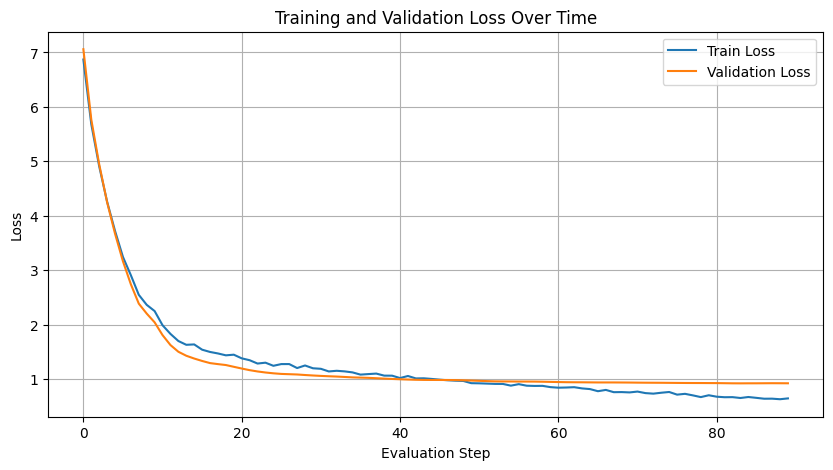

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

### 5. Inference

In [ ]:
checkpoint_path = "../output/fine_tuning/qa/base/run_2/checkpoint_9.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

input_message = f"{tokens['start']}system{tokens['separator']}{system_message}{tokens['end']}"

user_message = "¿Cómo te llamas?"
input_message += f"{tokens['start']}user{tokens['separator']}{user_message}{tokens['end']}"
input_message += f"{tokens['start']}assistant{tokens['separator']}"

input_tokens = tokenizer.encode(input_message, allowed_special="all")
input_tokens = torch.tensor(input_tokens, dtype=torch.long)
input_tokens = input_tokens.unsqueeze(0).to(device)

model_answer = ""

model.eval()
while True:
    try:
        output_tokens = model.advanced_generation(
            input_tokens=input_tokens, max_new_tokens=1, temperature=.9, top_k=50, top_p=None)
        last_generated_token = output_tokens[0, -1].item()
        if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
            break

        if last_generated_token == tokenizer.special_tokens["<|end_turn|>"]:
            break

        input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
        model_answer += tokenizer.decode([last_generated_token])

        if len(output_tokens[0]) > block_size:
            break
    except Exception:
        continue

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: شنو سميتك؟
Assistant: انا سميتي بودماغ.
